In [1]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [3]:
# M/D/1 queue

import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class BusSystem:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    bus_system = BusSystem(arrival_rate, service_rate)
    bus_system.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return bus_system

In [4]:
# Run a short test
bus_system = run_simulation(arrival_rate=1.2, service_rate=1, run_until=100)
print(f'There are {bus_system.queue.people_in_queue} people in the queue')

There are 57 people in the queue


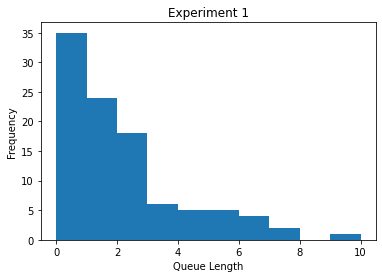

Sample mean: 1.71
95% confidence interval of population mean: [1.3137711935374876, 2.1062288064625125]


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def run_queue_len_experiment(trials, arrival_rate, service_rate):
    queue_lens = []
    for _ in range(trials):
        bus_system = run_simulation(arrival_rate, service_rate, run_until=100)
        q_len = bus_system.queue.people_in_queue
        queue_lens.append(q_len)
    return queue_lens

q_len_1 = run_queue_len_experiment(100, 0.8, 1)


plt.figure()
plt.hist(q_len_1)
plt.title('Experiment 1')
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.show()

mean = np.mean(q_len_1)
t_val = sts.sem(q_len_1)

print(f'Sample mean: {mean}')
print(f'95% confidence interval of population mean: [{mean - 1.96*t_val}, {mean + 1.96*t_val}]')

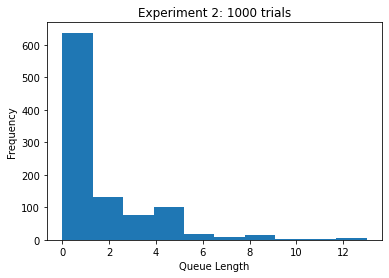

Sample mean: 1.554
95% confidence interval of population mean: [1.4193178215813853, 1.6886821784186148]


In [7]:
q_len_2 = run_queue_len_experiment(1000, 0.8, 1)


plt.figure()
plt.hist(q_len_2)
plt.title('Experiment 2: 1000 trials')
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.show()

mean = np.mean(q_len_2)
t_val = sts.sem(q_len_2)

print(f'Sample mean: {mean}')
print(f'95% confidence interval of population mean: [{mean - 1.96*t_val}, {mean + 1.96*t_val}]')

The distribution of the queue length is more skewed towards the left after 1000 trials. The estimate of average queue length hasn't changed much, but, the confidence interval has gotten smaller. This makes sense since the confidence interval is inversely proportional to the square root of the number of trials. As we increase the number of trials, we decrease the confidence interval.

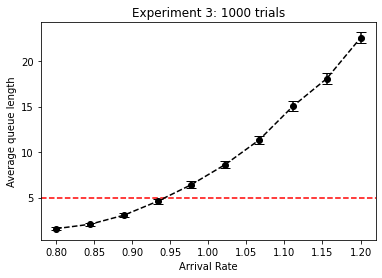

In [9]:
arrival_rates = np.linspace(0.8, 1.2, 10)
avg_q_lens = []
q_len_errors = []
for rate in arrival_rates:
    q_lens = run_queue_len_experiment(1000, rate, 1)
    avg_q_lens.append(np.mean(q_lens))
    q_len_errors.append(1.96*sts.sem(q_lens))

plt.figure()
plt.errorbar(arrival_rates, avg_q_lens, q_len_errors, color = 'black', marker = 'o', capsize=5, linestyle = '--')
plt.axhline(5, color = 'red', linestyle = '--')
plt.title('Experiment 3: 1000 trials')
plt.xlabel('Arrival Rate')
plt.ylabel('Average queue length')
plt.show()

As we can see from the figure above, the queue length becomes larger than 5 for arrival rate around 0.94 and for a service rate of 1. 

## Reflection

1. #empericalanalysis: The pre-class work was used to analyze the M/D/1 queue model. We ran the simulation for multiple trials to make sure we account for extreme results. We also provide confidence interval of our statistic to convey the variability in results. The results are interpreted correctly.

2. #professionalism: The work is professional, the plots have labels and titles. I make sure to answer all the prompts required, and produce the plots required to answer the questions. 